# Identifying Alternating Bit-Strings Using Grover's Algorithm ⚗️ 

## Step 1: Preprocessing 🤖 
Here, we take in the list of values and generate...
* a list of bitstring indices
* bitstring representations for each value in the list
* and a list of True/False values that indicate whether each value represents an alternating bitstring.

In [45]:
import numpy as np
def to_bitstring(n, max_len):
  s = ""
  while (len(s) < max_len):
    s += str(n%2)
    n //= 2
  return s[::-1]

In [46]:
def check_alternating(s):
  if (len(s) == 1): 
    return True
  for i in range(len(s) - 1):
    if (s[i] == s[i+1]):
      return False
  return True

## Step 2: Creating a Quantum Solution 👁️ 
Here, we instantiate general forms for 
* the oracle that recognizes the indices that correspond to truly alternating bitstrings, 
* the diffuser, which allows Grover's algorithm to refine its predictions,
* and the final ansatz, which puts the oracle and diffuser together.

In [47]:
#!pip install qiskit
from qiskit import *

In [48]:
def get_oracle(num_qubits, val_indices, alternating):
  index_reg = QuantumRegister(num_qubits, name="indices")
  checks = QuantumRegister(sum(alternating), name="checks")
  function_output = QuantumRegister(1, name="func")
  oracle = QuantumCircuit(index_reg, checks, function_output)

  idx = 0
  for inp, valid in zip(val_indices, alternating):
    if (valid):
      for i, x in enumerate(inp):
        if (x == '0'):
          oracle.x(index_reg[i])
      oracle.mct(index_reg, checks[idx])
      for i, x in enumerate(inp):
        if (x == '0'):
          oracle.x(index_reg[i])
      oracle.barrier()
      idx += 1
  
  oracle.x(checks)
  oracle.mct(checks, function_output)
  oracle.x(checks)
  oracle.x(function_output)
  
  return oracle

get_oracle(2, ["01", "00", "10", "11"], [True, False, True, False]).draw()

┌───┐     ┌───┐ ░                 ░                
indices_0: ┤ X ├──■──┤ X ├─░────────■────────░────────────────
           └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░                
indices_1: ───────■────────░─┤ X ├──■──┤ X ├─░────────────────
                ┌─┴─┐      ░ └───┘  │  └───┘ ░ ┌───┐     ┌───┐
 checks_0: ─────┤ X ├──────░────────┼────────░─┤ X ├──■──┤ X ├
                └───┘      ░      ┌─┴─┐      ░ ├───┤  │  ├───┤
 checks_1: ────────────────░──────┤ X ├──────░─┤ X ├──■──┤ X ├
                           ░      └───┘      ░ └───┘┌─┴─┐├───┤
   func_0: ────────────────░─────────────────░──────┤ X ├┤ X ├
                           ░                 ░      └───┘└───┘

The get_oracle function returns a QuantumCircuit that returns a 0 or 1 in the function_output register based on whether the input state indicated by val_indices represents an alternating bitstring. 

Each of the checks registers checks for one of the two possible alternating bitstrings (i.e. 1010... or 0101...) given the number of total qubits. 

At the end, function_output is set to 1 as long as both checks are not 0. The last section of the above circuit act like a classical OR gate on the two checks registers, composed of NOTs (Pauli X) and ANDs (multi-controlled Toffoli gates).

In [49]:
def diffuser(m):
  index_reg = QuantumRegister(m, name="indices")
  diff = QuantumCircuit(index_reg)

  diff.h(index_reg)
  diff.x(index_reg)

  diff.h(index_reg[-1])
  diff.mct(index_reg[:-1], index_reg[-1])
  diff.h(index_reg[-1])

  diff.x(index_reg)
  diff.h(index_reg)

  return diff

diffuser(2).draw()

┌───┐┌───┐          ┌───┐┌───┐     
indices_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
           ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
indices_1: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
           └───┘└───┘└───┘└───┘└───┘└───┘└───┘

diffuser returns a QuantumCircuit that acts to amplify the probabilities of the correct state in Grover search. This is the canonical formulation of this circuit, copied from the original paper.

In [50]:
def grover_alternating_circuit(num_qubits, val_indices, alternating, iters=1):
  index_reg = QuantumRegister(num_qubits, name="indices")
  checks = QuantumRegister(sum(alternating), name="checks")
  function_output = QuantumRegister(1, name="func")
  measurements = ClassicalRegister(num_qubits, name="measure")

  oracle = get_oracle(num_qubits, val_indices, alternating)
  diffuse = diffuser(num_qubits)
  grover_alternating = QuantumCircuit(index_reg, checks, function_output, measurements)

  grover_alternating.h(index_reg)

  grover_alternating.z(function_output)

  for _ in range(iters):
    grover_alternating += oracle
    grover_alternating.barrier()
    grover_alternating += diffuse

  grover_alternating.x(function_output)

  grover_alternating.measure(index_reg, measurements)

  return grover_alternating

grover_alternating_circuit returns the total Grover's Algorithm circuit, comprised of layers of oracles and diffusers. 

The index registers (that represent the indices of the original input array) are set to a superposition of all possible states. A Z gate is applied to the function_output register to exploit the phase kickback effect.

## Step 3: Simulating the Quantum Circuit 📈 
Finally, we are ready to run the final circuit! 

Some test cases are included to prove the algorithms effectiveness, and results are plotted to analyze the effects of hyperparamaters like diffusion count on the final results.

In [51]:
from matplotlib import pyplot as plt
# Utilities for parameter extraction and data visualization 

def plot_results(counts, val_indices, alternating):
  # Qiskit stores registers in reverse order, so we reverse again before plotting.
  plt.title("Correct indices: " + str([x for x, y in zip(val_indices, alternating) if y]))
  plt.bar([x[::-1] for x in dict(counts).keys()], dict(counts).values())
  plt.xticks(rotation=45)
  plt.show()

def get_ind_bitstring_and_alternating(num_qubits, values):
  val_indices = list(map(lambda x: to_bitstring(x, num_qubits), range(2**num_qubits)))
  val_bitstrings = list(map(lambda x: to_bitstring(x, np.floor(np.log2(max(values))) + 1), values))
  alternating = list(map(check_alternating, val_bitstrings))
  return val_indices, val_bitstrings, alternating

In [80]:
# MODIFY THIS SECTION WITH TEST CASES - (1) num_qubits and (2) values = list of 2^(num_qubits) vals
num_qubits = 3
values = [1, 4, 5, 7, 10, 8, 3, 2]

grover_iters = 2

In [81]:
val_indices, val_bitstrings, alternating = get_ind_bitstring_and_alternating(num_qubits, values)
# Verify that bitstrings match with results of check_alternating
print(val_bitstrings)
print(alternating)

['0001', '0100', '0101', '0111', '1010', '1000', '0011', '0010']
[False, False, True, False, True, False, False, False]


In [82]:
gac = grover_alternating_circuit(num_qubits, val_indices, alternating, iters=grover_iters)
gac.draw()

┌───┐┌───┐     ┌───┐ ░                 ░                 ░ ┌───┐»
indices_0: ┤ H ├┤ X ├──■──┤ X ├─░────────■────────░─────────────────░─┤ H ├»
           ├───┤└───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░                 ░ ├───┤»
indices_1: ┤ H ├───────■────────░─┤ X ├──■──┤ X ├─░─────────────────░─┤ H ├»
           ├───┤┌───┐  │  ┌───┐ ░ ├───┤  │  ├───┤ ░                 ░ ├───┤»
indices_2: ┤ H ├┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░─────────────────░─┤ H ├»
           └───┘└───┘┌─┴─┐└───┘ ░ └───┘  │  └───┘ ░ ┌───┐     ┌───┐ ░ └───┘»
 checks_0: ──────────┤ X ├──────░────────┼────────░─┤ X ├──■──┤ X ├─░──────»
                     └───┘      ░      ┌─┴─┐      ░ ├───┤  │  ├───┤ ░      »
 checks_1: ─────────────────────░──────┤ X ├──────░─┤ X ├──■──┤ X ├─░──────»
           ┌───┐                ░      └───┘      ░ └───┘┌─┴─┐├───┤ ░      »
   func_0: ┤ Z ├────────────────░─────────────────░──────┤ X ├┤ X ├─░──────»
           └───┘                ░                 ░      └───┘└───┘ ░      »
measure: 3/════════════════════════════════════════════════════════════════»
                                                                           »
«           ┌───┐          ┌───┐┌───┐┌───┐          ┌───┐ ░                 ░ »
«indices_0: ┤ X ├───────■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├─░────────■────────░─»
«           ├───┤       │  ├───┤├───┤└───┘       │  └───┘ ░ ┌───┐  │  ┌───┐ ░ »
«indices_1: ┤ X ├───────■──┤ X ├┤ H ├────────────■────────░─┤ X ├──■──┤ X ├─░─»
«           ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐  │  ┌───┐ ░ ├───┤  │  ├───┤ ░ »
«indices_2: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░─»
«           └───┘└───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐└───┘ ░ └───┘  │  └───┘ ░ »
« checks_0: ───────────────────────────────────┤ X ├──────░────────┼────────░─»
«                                              └───┘      ░      ┌─┴─┐      ░ »
« checks_1: ──────────────────────────────────────────────░──────┤ X ├──────░─»
«                                                         ░      └───┘      ░ »
«   func_0: ──────────────────────────────────────────────░─────────────────░─»
«                                                         ░                 ░ »
«measure: 3/══════════════════════════════════════════════════════════════════»
«                                                                             »
«                           ░ ┌───┐┌───┐          ┌───┐┌───┐     ┌─┐      
«indices_0: ────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├──────
«                           ░ ├───┤├───┤       │  ├───┤├───┤     └╥┘┌─┐   
«indices_1: ────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
«                           ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
«indices_2: ────────────────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
«           ┌───┐     ┌───┐ ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
« checks_0: ┤ X ├──■──┤ X ├─░─────────────────────────────────────╫──╫──╫─
«           ├───┤  │  ├───┤ ░                                     ║  ║  ║ 
« checks_1: ┤ X ├──■──┤ X ├─░─────────────────────────────────────╫──╫──╫─
«           └───┘┌─┴─┐├───┤ ░ ┌───┐                               ║  ║  ║ 
«   func_0: ─────┤ X ├┤ X ├─░─┤ X ├───────────────────────────────╫──╫──╫─
«                └───┘└───┘ ░ └───┘                               ║  ║  ║ 
«measure: 3/══════════════════════════════════════════════════════╩══╩══╩═
«                                                                 0  1  2

In [83]:
backend = Aer.get_backend("qasm_simulator")
job = execute(gac, backend=backend)
result = job.result()
counts = result.get_counts()

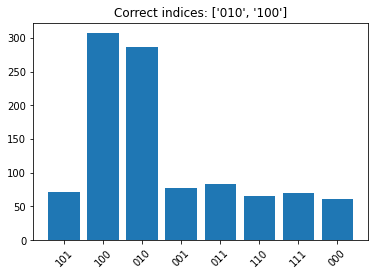

In [84]:
plot_results(counts, val_indices, alternating)

## Step 4: Running on Real Quantum Computers 🕹️ 
I further show that my implementation is correct by running the algorithm on real IBM quantum computers and plotting the results. 

In [69]:
# MODIFY TEST CASES
num_qubits = 2
values = [1, 4, 5, 7]

grover_iters = 1

In [70]:
val_indices, val_bitstrings, alternating = get_ind_bitstring_and_alternating(num_qubits, values)
gac = grover_alternating_circuit(num_qubits, val_indices, alternating, iters=grover_iters)
# gac.draw()

In [71]:
# Note: can only run currently for num_qubits=2 (4 values in list) because only 5-qubit machines are available.
IBMQ.save_account("d25fd280c37d42ee57d1047e4b5e9b0e1682978c9646e359a69781dd1602c55a9094bb7b0916bbb1399054b4380ffdeab12139cd156667877c94cc186f9873f7")
IBMQ.load_account()
provider = IBMQ.get_provider()

configrc.store_credentials:WARNING:2021-09-26 18:38:40,766: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-09-26 18:38:41,023: Credentials are already in use. The existing account in the session will be replaced.


In [72]:
from qiskit.tools.monitor import job_monitor
job = execute(gac, backend=provider.get_backend('ibmq_belem'))

job_monitor(job)

Job Status: job has successfully run


In [73]:
result = job.result()
counts = result.get_counts()

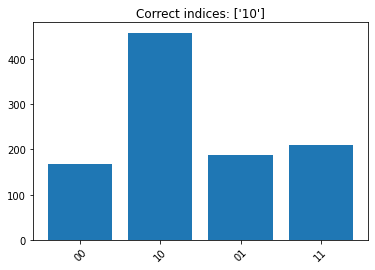

In [74]:
plot_results(counts, val_indices, alternating)

# Conclusion 🎉 
Although there is much more noise in the real Quantum Computer run than in the QASM runs, it is still clear that the correct index was identified by the circuit. 

After testing increasingly higher values of num_qubits on the QASM simulator, it is clear that my implementation works for all power of 2. 

**Thank you so much to the Quantum Open Source Foundation for the challenge!** 🥳 